# Predicting the Titanic with CatBoost

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline  

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
def optimize_memory_usage(df, print_size=True):
    # Function optimizes memory usage in dataframe.
    # (RU) Функция оптимизации типов в dataframe.
    
    # Types for optimization.
    # Типы, которые будем проверять на оптимизацию.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Memory usage size before optimize (Mb).
    # (RU) Размер занимаемой памяти до оптимизации (в Мб).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in tqdm(df.columns):
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64) 
                    
            elif str(column_type).startswith('float'):
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
                    
        elif str(column_type).startswith('object'):
            df[column] = df[column].astype('category')
        else:
            pass
    # Memory usage size after optimize (Mb).
    # (RU) Размер занимаемой памяти после оптимизации (в Мб).
    after_size = df.memory_usage().sum() / 1024**2

    if print_size: print(f'Memory usage size: before {before_size:5.4f} Mb - after {after_size:5.4f} Mb ({100 * (before_size - after_size) / before_size:.1f}%).')
    return df

# Task:
#### Your task is to predict whether the passenger survived the Titanic crash or not.
#### For each in the test set, you must predict a value of 0 or 1 for the variable.

# Zadanie :
#### Twoim zadaniem jest przewidzieć, czy pasażer przeżył katastrofę Titanica, czy nie.
#### Dla każdego w zbiorze testowym należy przewidzieć wartość 0 lub 1 dla zmiennej.

In [5]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test  = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission  = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# EDA
# Zapoznanie się z danymi.

In [6]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
percent_nan = train.isna().sum()/ train.isna().count()
percent_nan, percent_nan[percent_nan < 0.1]

(PassengerId    0.000000
 Survived       0.000000
 Pclass         0.000000
 Name           0.000000
 Sex            0.000000
 Age            0.198653
 SibSp          0.000000
 Parch          0.000000
 Ticket         0.000000
 Fare           0.000000
 Cabin          0.771044
 Embarked       0.002245
 dtype: float64,
 PassengerId    0.000000
 Survived       0.000000
 Pclass         0.000000
 Name           0.000000
 Sex            0.000000
 SibSp          0.000000
 Parch          0.000000
 Ticket         0.000000
 Fare           0.000000
 Embarked       0.002245
 dtype: float64)

In [8]:
died = train[train.Survived == 0]
survived = train[train.Survived == 1]

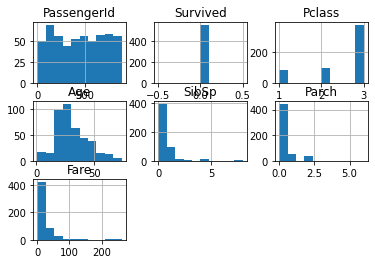

In [9]:
died.hist();

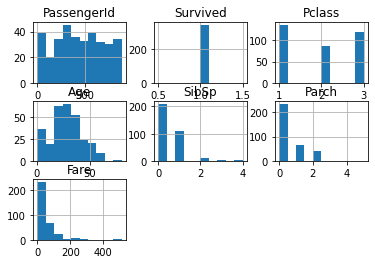

In [10]:
survived.hist();

In [11]:
d_nan = died.isna().sum()/ died.isna().count()
d_nan[d_nan > 0]

Age      0.227687
Cabin    0.876138
dtype: float64

In [12]:
s_nan = survived.isna().sum()/ survived.isna().count()
s_nan[s_nan > 0]

Age         0.152047
Cabin       0.602339
Embarked    0.005848
dtype: float64

# Data processing 
# Przetwarzanie danych 

In [13]:
#  transforming qualitative data into quantitative data 
# replace the NAN type

def  data_processing(data):
    df = data.copy()
    
    #  przekształcanie danych jakościowych w ilościowe 
    #  transforming qualitative data into quantitative data 
    sex_emb = {"Sex":      {"female": 0, "male": 1},
              "Embarked": { "S":0, "C":1, "Q":3 } }
    df.replace(sex_emb, inplace=True )
    
     # uzupełnienie typ NAT
     # completion of the NAT type
    values = { "Age":       df.Age.mean(), 
               "Embarked":  df.Embarked.mean()
             }
    
    df = df.fillna(value=values)
    
    return df
train = data_processing(train)

In [14]:
# correlation data
def correlation(data=pd.DataFrame, nam_columt=str) -> dict :
    corr = dict()       
    for i in data.select_dtypes('number').columns:
        corr[nam_columt+"_"+i] = { data[nam_columt].corr(data[i]) }
    return corr

correlation(train, "Survived")

{'Survived_PassengerId': {-0.005006660767066504},
 'Survived_Survived': {1.0},
 'Survived_Pclass': {-0.3384810359610148},
 'Survived_Sex': {-0.5433513806577555},
 'Survived_Age': {-0.06980851528714314},
 'Survived_SibSp': {-0.03532249888573564},
 'Survived_Parch': {0.08162940708348371},
 'Survived_Fare': {0.2573065223849625},
 'Survived_Embarked': {0.08019893336023073}}

In [15]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.033207,-0.057527,-0.001652,0.012658,-0.032919
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.069809,-0.035322,0.081629,0.257307,0.080199
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.331339,0.083081,0.018443,-0.549500,0.102370
Sex,0.042939,-0.543351,0.131900,1.000000,0.084153,-0.114631,-0.245489,-0.182333,-0.110019
Age,0.033207,-0.069809,-0.331339,0.084153,1.000000,-0.232625,-0.179191,0.091566,0.002767
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.232625,1.000000,0.414838,0.159651,-0.052555
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.179191,0.414838,1.000000,0.216225,-0.083762
Fare,0.012658,0.257307,-0.549500,-0.182333,0.091566,0.159651,0.216225,1.000000,0.008588
Embarked,-0.032919,0.080199,0.102370,-0.110019,0.002767,-0.052555,-0.083762,0.008588,1.000000


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.7+ KB


# Data processing for model
# Przetwarzanie danych dla modelu

In [17]:
def removal_gaps(data) :
    """
    removal of data with large gaps and 
    data not participating in the prediction
    """
    df = data.copy()
    
    # likwidujemy zbędne dane które nie potrzebujemy 
    # we eliminate redundant data that we do not need
    df = df.drop(["Name","PassengerId","Ticket","Cabin"], axis=1 )

    return df
train = removal_gaps(train)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


# model preparation

In [19]:
X = train.drop("Survived",axis=1)
y = train.Survived

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Predictive model preparation

In [21]:
rfc = RandomForestClassifier(random_state=0)

params = {
         "max_depth" : list(range(5,15,1)),
         "n_estimators" : list(range(100,600,100)),
         "criterion" : ["gini","entropy"],
         "bootstrap" : [True, False ] , 
    } 

rscv = RandomizedSearchCV(estimator = rfc, param_distributions = params, cv=5, n_iter=21, n_jobs = -1, random_state = 0  )

# Fit mofel predict

In [22]:
search  = rscv.fit( X_train, y_train )
best_p = search.best_params_

In [23]:
rfc = RandomForestClassifier(**best_p, random_state=0)
rfc.fit(  X_train, y_train )

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=500,
                       random_state=0)

# Predicr

In [24]:
p_train = rfc.predict(X_train)
p_test  = rfc.predict(X_test)

In [25]:
from sklearn.metrics import f1_score

print( f1_score( p_train, y_train , average='macro'))
print( f1_score( p_test, y_test , average='macro'))

0.9178229859988218
0.8148284901968024


# Setting predictions

In [26]:
pred_p_tr = rfc.predict_proba(X_train)
pred_p_ts = rfc.predict_proba(X_test)


pct = 0
percent = 0.01
old_bill = 0
for j in range(100):

    pred_p = np.where( pred_p_ts[:, 1] > percent  , 1, 0 )
    scor = f1_score(pred_p, y_test, average='macro')

    if scor > old_bill:
        old_bill = scor
        pct = percent
            
    percent += 0.01

In [27]:
pred_prob_train = np.where( pred_p_tr[:, 1] > pct, 1, 0 )
pred_prob_test = np.where( pred_p_ts[:, 1] > pct, 1, 0 )

print("After promotion")
print( f1_score( pred_prob_train, y_train, average='macro'))
print( f1_score( pred_prob_test, y_test, average='macro'))
print("\n")

After promotion
0.9178229859988218
0.8148284901968024




In [28]:
########################################################################3

# Predict 

In [29]:
test = removal_gaps(test)
test = data_processing(test)

In [30]:
test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [31]:
values = { "Fare": test.Fare.mean() }
test = test.fillna(values)

In [32]:
pred_proba = rfc.predict_proba(test)
predict = np.where( pred_proba[:, 1] > pct, 1, 0 )

In [33]:
print( f1_score( predict, gender_submission["Survived"], average='macro'))

0.86757400648824


<AxesSubplot:>

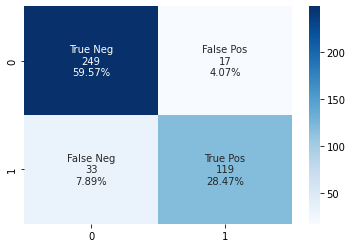

In [34]:
# Confusion Matrix
cf_matrix = confusion_matrix(gender_submission["Survived"], predict )


group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [35]:
gender_submission["Survived"] = predict
# gender_submission.to_csv(r"C:\Users\user\PycharmProjects\Kaggle\Titanik\predict.csv", index=False)